# Chinese NLP Evaluation Project_Neural Network Classifier

This is a Chinese NLP evaluation project finished by Yiting Luo.

## Data Set Description

Training data is from: ChnSentiCorp: https://pan.baidu.com/s/1hsF1Zbm. Data includes negative and positive hotel evaluation.

Testing data is split from training data set.

## Data Importing and Pre-processing

In [1]:
# Change working directory
import os
os.chdir('/Users/luoyiting/Desktop/nlpdatachallenge')
print (os.getcwd())

/Users/luoyiting/Desktop/nlpdatachallenge


In [2]:
# Import packages

from os import listdir
from os.path import isfile, join
import jieba
import codecs
from langconv import * # convert Traditional Chinese characters to Simplified Chinese characters
import pickle
import random
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import pylab as pl

/Users/luoyiting/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/luoyiting/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
# import data from original folder
dataBaseDirPos = "ChnSentiCorp情感分析酒店评论/正面/"
dataBaseDirNeg = "ChnSentiCorp情感分析酒店评论/负面/"
positiveFiles = [dataBaseDirPos + f for f in listdir(dataBaseDirPos) if isfile(join(dataBaseDirPos, f))]
negativeFiles = [dataBaseDirNeg + f for f in listdir(dataBaseDirNeg) if isfile(join(dataBaseDirNeg, f))]

In [4]:
# Check if our data is balanced
print(len(positiveFiles))
print(len(negativeFiles))

2001
2001


In [5]:
# Merge positive and negative comments and generate a data document
documents = []
for filename in positiveFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("utf-8")
            except:
                continue
            text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese

            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "pos"))

for filename in negativeFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("utf-8")
            except:
                continue
            text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese

            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "neg"))

In [6]:
# Shuffle dataset: documents
random.shuffle(documents)

## Prepare text and target

In [7]:
# Tokenize and remove stop words
totalX = []
totalY = [str(doc[1]) for doc in documents]  #label: pos/neg
stopwords = [ line.rstrip() for line in codecs.open('chinese_stop_words.txt',"r", encoding="utf-8") ]
for doc in documents:
    seg_list = jieba.cut(doc[0], cut_all=False)
    seg_list = list(seg_list)
    final =[]
    for seg in seg_list:
        if seg not in stopwords:
            final.append(seg)
    totalX.append(final)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/lp/xhvxtxys4f3b6nwg_3dcfkmw0000gn/T/jieba.cache
Loading model cost 1.330 seconds.
Prefix dict has been built succesfully.


In [8]:
# Check if our text and target are balanced
print("Number of text:", len(totalX))
print("Number of label:", len(totalY))

Number of text: 4002
Number of label: 4002


In [9]:
h = sorted([len(sentence) for sentence in totalX])
maxLength = h[int(len(h))-1]
print("Max length is: ",maxLength)

Max length is:  514


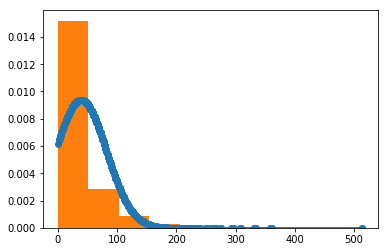

In [10]:
# Draw a plot to see distribution of text_length
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #fit text_length with a normal function
pl.plot(h,fit,'-o')
pl.hist(h,normed=True)      #draw histogram of text_length
pl.show()

## Words to Number Tokens, padding

In [ ]:
totalX = [" ".join(str(wordslist)) for wordslist in totalX]  # Keras Tokenizer expect the words tokens to be seperated by space 
input_tokenizer = Tokenizer(30000) # Initial vocab size
input_tokenizer.fit_on_texts(totalX)
vocab_size = len(input_tokenizer.word_index) + 1
print("input vocab_size:",vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))

## Convert Output Label to 0s and 1s

In [21]:
target_tokenizer = Tokenizer(3)
target_tokenizer.fit_on_texts(totalY)
print("output vocab_size:",len(target_tokenizer.word_index) + 1)
totalY = np.array(target_tokenizer.texts_to_sequences(totalY)) -1
totalY = totalY.reshape(totalY.shape[0])

output vocab_size: 3


## Turn output 0s and 1s to categories(one-hot vectors)

In [27]:
totalY = to_categorical(totalY, num_classes=2)

In [36]:
output_dimen = totalY.shape[1]

## Save meta data for later predition

maxLength: the input sequence length

vocab_size: Input vocab size

output_dimen: which is 2 in this example (pos or neg)

sentiment_tag: either ["neg","pos"] or ["pos","neg"] matching the target tokenizer

In [37]:
target_reverse_word_index = {v: k for k, v in list(target_tokenizer.word_index.items())}
sentiment_tag = [target_reverse_word_index[1],target_reverse_word_index[2]] 
metaData = {"maxLength":maxLength,"vocab_size":vocab_size,"output_dimen":output_dimen,"sentiment_tag":sentiment_tag}

## Build a Neural Network Classifier Model, Train and Save it

In [39]:
embedding_dim = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length = maxLength))
# Each input would have a size of (maxLength x 256) and each of these 256 sized vectors are fed into the GRU layer one at a time.
# All the intermediate outputs are collected and then passed on to the second GRU layer.
model.add(GRU(256, dropout=0.9, return_sequences=True))
# Using the intermediate outputs, we pass them to another GRU layer and collect the final output only this time
model.add(GRU(256, dropout=0.9))
# The output is then sent to a fully connected layer that would give us our final output_dim classes
model.add(Dense(output_dimen, activation='softmax'))
# We use the adam optimizer instead of standard SGD since it converges much faster
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(totalX, totalY, validation_split=0.1, batch_size=32, epochs=20, verbose=1)
model.save('sentiment_chinese_model.HDF5')

print("Saved model!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 514, 256)          764160    
_________________________________________________________________
gru_3 (GRU)                  (None, 514, 256)          393984    
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 1,552,642
Trainable params: 1,552,642
Non-trainable params: 0
_________________________________________________________________
Train on 3601 samples, validate on 401 samples
Epoch 1/20
3601/3601 [==============================] - 530s 147ms/step - loss: 0.7013 - acc: 0.5099 - val_loss: 0.6956 - val_acc: 0.4963
Epoch 2/20
3601/3601 [==============================] - 522s 145ms/step - loss:

From the training procedure above, we can see training accuracy keeps going up to 88.61%, while validation accuracy fluctuate around 85%.

So accuracy of a Keras Neural network classifier is around 85%.